In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.interpolate import BSpline
from scipy.interpolate import interp1d

import emcee
import pickle
import numpyro
from numpyro.infer import MCMC, NUTS
import numpyro.distributions as dist
from jax import random

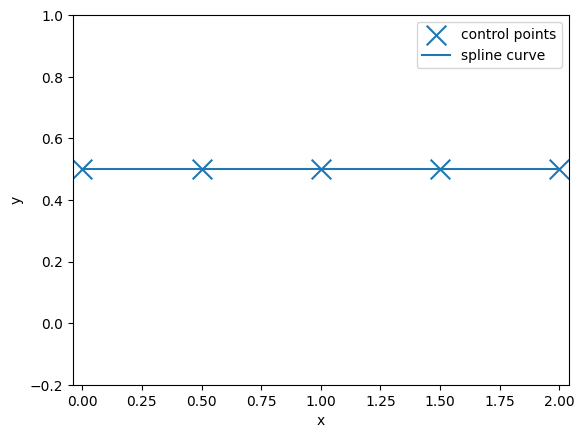

In [15]:
cont_x_pts = [0.0, 0.5, 1.0, 1.5, 2.0]
cont_y_pts = [0.5, 0.5, 0.5, 0.5, 0.5]

x_grid = np.linspace(0,2,1000)
spline_curve = CubicSpline(cont_x_pts, cont_y_pts, bc_type='natural')(x_grid)

plt.scatter(cont_x_pts, cont_y_pts, label='control points', marker='x', s=200)
plt.plot(x_grid, spline_curve, label='spline curve');
plt.xlim(-0.04,2.04)
plt.ylim(-0.2,1)
plt.xlabel('x')
plt.ylabel('y')
plt.legend();

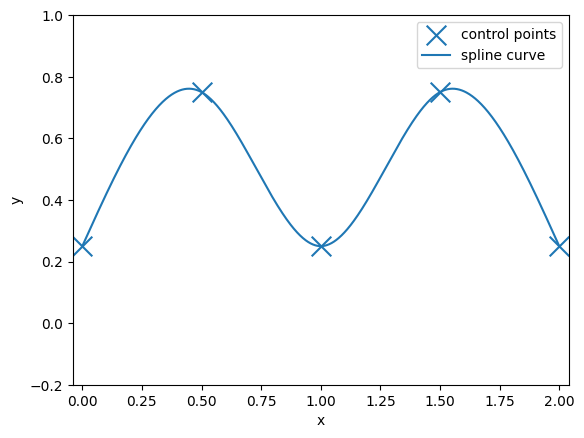

In [16]:
cont_y_pts = [0.25, 0.75, 0.25, 0.75, 0.25]

spline_curve = CubicSpline(cont_x_pts, cont_y_pts, bc_type='natural')(x_grid)

plt.scatter(cont_x_pts, cont_y_pts, label='control points', marker='x', s=200)
plt.plot(x_grid, spline_curve, label='spline curve');
plt.xlim(-0.04,2.04)
plt.ylim(-0.2,1)
plt.xlabel('x')
plt.ylabel('y')
plt.legend();

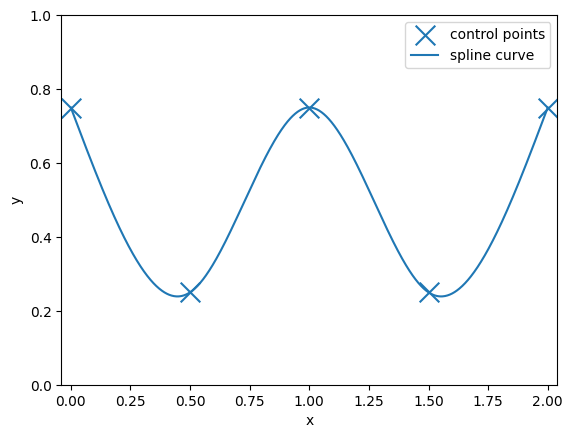

In [17]:
cont_y_pts = [0.75, 0.25, 0.75, 0.25, 0.75]

spline_curve = CubicSpline(cont_x_pts, cont_y_pts, bc_type='natural')(x_grid)

plt.scatter(cont_x_pts, cont_y_pts, label='control points', marker='x', s=200)
plt.plot(x_grid, spline_curve, label='spline curve');
plt.xlim(-0.04,2.04)
plt.ylim(0,1)
plt.xlabel('x')
plt.ylabel('y')
plt.legend();

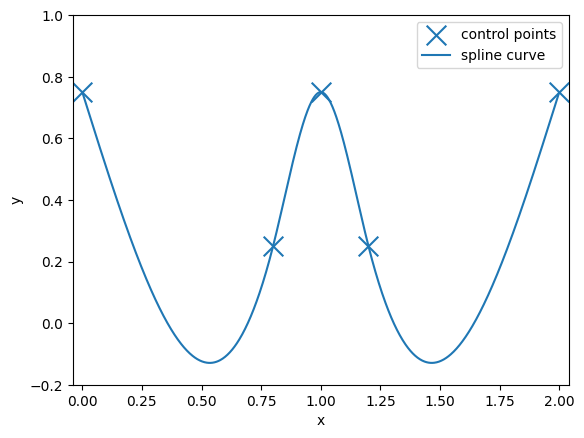

In [18]:
cont_x_pts = [0.0, 0.8, 1.0, 1.2, 2.0]

spline_curve = CubicSpline(cont_x_pts, cont_y_pts, bc_type='natural')(x_grid)

plt.scatter(cont_x_pts, cont_y_pts, label='control points', marker='x', s=200)
plt.plot(x_grid, spline_curve, label='spline curve');
plt.xlim(-0.04,2.04)
plt.ylim(-0.2,1)
plt.xlabel('x')
plt.ylabel('y')
plt.legend();

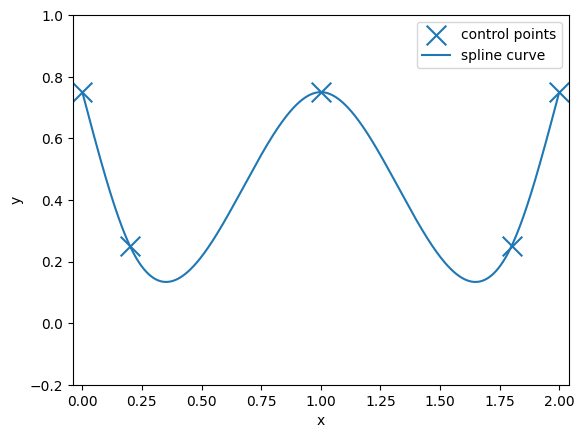

In [19]:
cont_x_pts = [0.0, 0.2, 1.0, 1.8, 2.0]

spline_curve = CubicSpline(cont_x_pts, cont_y_pts, bc_type='natural')(x_grid)

plt.scatter(cont_x_pts, cont_y_pts, label='control points', marker='x', s=200)
plt.plot(x_grid, spline_curve, label='spline curve');
plt.xlim(-0.04,2.04)
plt.ylim(-0.2,1)
plt.xlabel('x')
plt.ylabel('y')
plt.legend();

<AxesSubplot: xlabel='$x$', ylabel='$y$'>

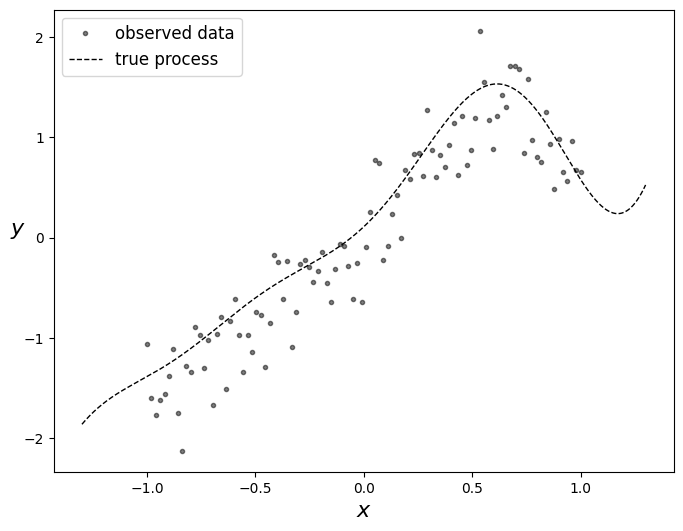

In [2]:
def get_data(N=30, sigma_obs=0.15, N_test=400):
    X = np.linspace(-1, 1, N)
    Y = X + 0.2 * np.power(X, 3.0) + 0.5 * np.power(0.5 + X, 2.0) * np.sin(4.0 * X)
    Y += sigma_obs * np.random.randn(N)
    Y -= np.mean(Y)
    Y /= np.std(Y)
    assert X.shape == (N,)
    assert Y.shape == (N,)

    X_test = np.linspace(-1.3, 1.3, N_test)
    Y_test = X_test + 0.2 * np.power(X_test, 3.0) + 0.5 * np.power(0.5 + X_test, 2.0) * np.sin(4.0 * X_test)
    Y_test -= np.mean(Y_test)
    Y_test /= np.std(Y_test)

    return X, Y, X_test, Y_test

def plot_data(X, Y, X_test, Y_test, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.plot(X, Y, 'ok', ms=3, alpha=0.5, label='observed data')
    ax.plot(X_test, Y_test, '--k', lw=1, label='true process')
    ax.legend(loc='best', fontsize=12)
    ax.set_xlabel('$x$', fontsize=16)
    ax.set_ylabel('$y$', fontsize=16, rotation=0)
    return ax

X, Y, X_test, Y_test = get_data(N=100, sigma_obs=0.25, N_test=1000)   
plot_data(X, Y, X_test, Y_test)

In [3]:
from jax_cosmo.scipy.interpolate import InterpolatedUnivariateSpline
import arviz as az
from collections import namedtuple
from numpyro.infer.mcmc import MCMCKernel
from numpyro.infer.util import initialize_model, init_to_uniform
import jax.numpy as jnp
from jax import lax, random, vmap
from numpyro.util import identity
from jax.flatten_util import ravel_pytree

az.style.use('arviz-darkgrid')

In [23]:
MHState = namedtuple("MHState", ["i", "u", "accept_prob", "mean_accept_prob", "rng_key"])

class MH(MCMCKernel):
    def __init__(
        self,
        model=None,
        potential_fn=None,
        step_size=1.0,
        init_strategy=init_to_uniform,
    ):
        if not (model is None) ^ (potential_fn is None):
            raise ValueError("Only one of `model` or `potential_fn` must be specified.")
        self._model = model
        self._potential_fn = potential_fn
        self._step_size = step_size
        self._init_strategy = init_strategy
        self._postprocess_fn = None

    def _init_state(self, rng_key, model_args, model_kwargs, init_params):
        if self._model is not None:
            (
                params_info,
                potential_fn_gen,
                self._postprocess_fn,
                model_trace,
            ) = initialize_model(
                rng_key,
                self._model,
                dynamic_args=True,
                init_strategy=self._init_strategy,
                model_args=model_args,
                model_kwargs=model_kwargs,
            )
            init_params = params_info[0]
            model_kwargs = {} if model_kwargs is None else model_kwargs
            self._potential_fn = potential_fn_gen(*model_args, **model_kwargs)
        return init_params

    @property
    def model(self):
        return self._model

    @property
    def sample_field(self):
        return "u"

    def get_diagnostics_str(self, state):
        return "acc. prob={:.2f}".format(state.mean_accept_prob)


    def postprocess_fn(self, args, kwargs):
        if self._postprocess_fn is None:
            return identity
        return self._postprocess_fn(*args, **kwargs)

    def init(self, rng_key, num_warmup, init_params, model_args, model_kwargs):
        self._num_warmup = num_warmup
        rng_key, rng_key_init_model = random.split(rng_key)
        init_params = self._init_state(
            rng_key_init_model, model_args, model_kwargs, init_params
        )
        if self._potential_fn and init_params is None:
            raise ValueError(
                "Valid value of `init_params` must be provided with" " `potential_fn`."
            )
        
        return MHState(jnp.array(0), init_params, jnp.zeros(()), jnp.zeros(()), rng_key)


    def sample(self, state, model_args, model_kwargs):
        i, u, _, mean_accept_prob, rng_key = state
        u_flat, _ = ravel_pytree(u)
        rng_key, key_proposal, key_accept = random.split(rng_key, 3)
        u_proposal = dist.Normal(u_flat, self._step_size).sample(key_proposal)
        accept_prob = jnp.exp(self._potential_fn(u) - self._potential_fn(u_proposal))
        u_new = jnp.where(dist.Uniform().sample(key_accept) < accept_prob, u_proposal, u)
        itr = i+1
        n = jnp.where(i < self._num_warmup, itr, itr - self._num_warmup)
        mean_accept_prob = mean_accept_prob + (accept_prob - mean_accept_prob) / n
        return MHState(itr, u_new, accept_prob, mean_accept_prob, rng_key)


[-1.85714286 -1.57142857 -1.28571429 -1.         -0.71428571 -0.42857143
 -0.14285714  0.14285714  0.42857143  0.71428571  1.          1.28571429
  1.57142857  1.85714286]


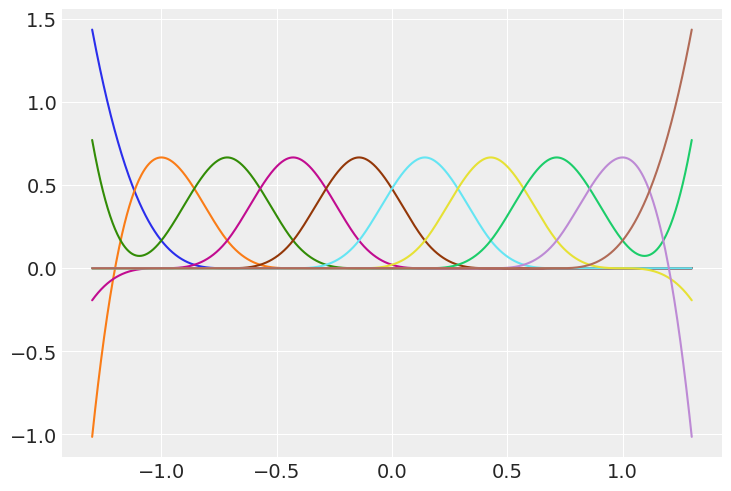

In [20]:
def bspline_model(dmat, Y):
    N_knots = dmat.shape[0]
    sigma = numpyro.sample('sigma', dist.HalfNormal())
    cs = numpyro.sample('cs', dist.Normal(0, 1), sample_shape=(N_knots,))
    numpyro.sample('obs', dist.Normal(jnp.einsum('i...,i->...', dmat, cs), sigma), obs=Y)

N = 10
interior_knots = np.linspace(-1, 1, N-2)
dx = interior_knots[1] - interior_knots[0]
knots = np.concatenate([[-1-3*dx, -1-2*dx, -1-dx], interior_knots, [1+dx, 1+2*dx, 1+3*dx]])
print(knots)
dmat = BSpline(knots, np.diag(np.ones(N)), k=3)(X).T
dmat_test = BSpline(knots, np.diag(np.ones(N)), k=3)(X_test).T
for i in range(10):
    plt.plot(X_test, dmat_test[i,:])

In [21]:

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
num_warmup, num_samples = 100, 1000
kernel = NUTS(bspline_model)
mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=1)
mcmc.run(rng_key_, dmat, Y)
mcmc.print_summary()

sample: 100%|██████████| 1100/1100 [00:02<00:00, 388.50it/s, 7 steps of size 2.66e-01. acc. prob=0.96]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     cs[0]     -0.16      0.94     -0.17     -1.70      1.39    724.20      1.00
     cs[1]     -1.74      0.27     -1.74     -2.21     -1.33    585.01      1.00
     cs[2]     -1.24      0.21     -1.24     -1.62     -0.92    619.85      1.00
     cs[3]     -0.60      0.19     -0.61     -0.91     -0.30    507.35      1.00
     cs[4]     -0.42      0.18     -0.41     -0.69     -0.11    517.35      1.00
     cs[5]      0.36      0.19      0.37      0.02      0.64    522.73      1.00
     cs[6]      1.05      0.19      1.05      0.74      1.36    521.81      1.00
     cs[7]      1.61      0.21      1.61      1.29      1.98    551.33      1.00
     cs[8]      0.31      0.27      0.31     -0.10      0.79    590.72      1.00
     cs[9]      0.41      0.91      0.43     -1.04      1.87    711.69      1.00
     sigma      0.32      0.02      0.32      0.29      0.36    691.61      1.00

Number of divergences: 0


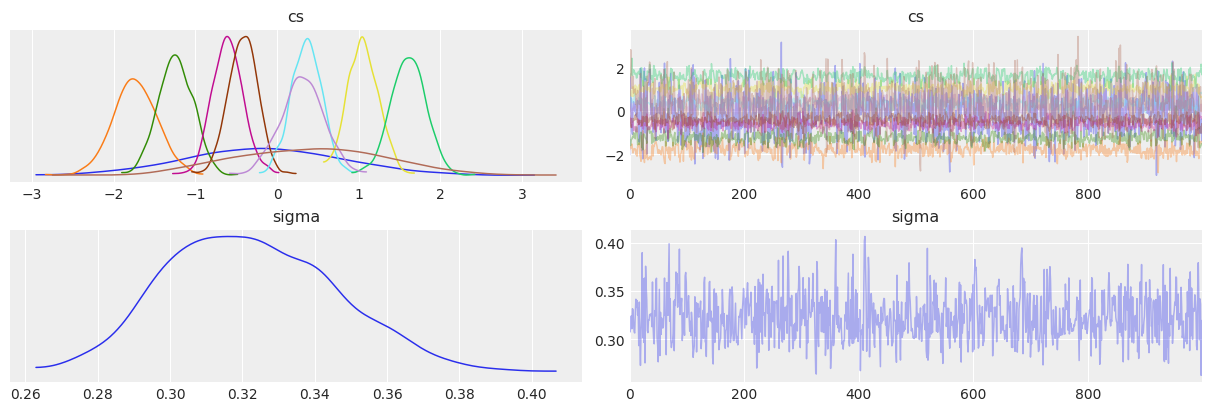

In [22]:
az.plot_trace(mcmc);

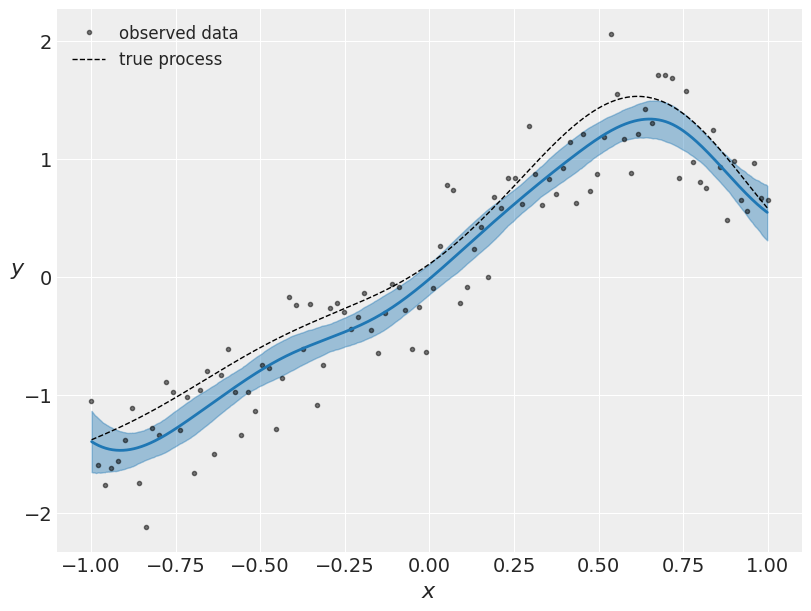

In [23]:
samples = mcmc.get_samples()
sel = (X_test >= -1) & (X_test <= 1)
dmat_test = BSpline(knots, np.eye(N), k=3)(X_test[sel]).T
curves = []
for idx in range(1000):
    cs = samples['cs'][idx]
    curve = jnp.einsum('i...,i->...', dmat_test, cs)
    curves.append(curve)

curves = np.array(curves)
mean = np.mean(curves, axis=0)
low, high = np.percentile(curves, (5, 95), axis=0)
plot_data(X, Y, X_test[sel], Y_test[sel])
plt.plot(X_test[sel], mean, 'tab:blue', lw=2, label='mean')
plt.fill_between(X_test[sel], low, high, color='tab:blue', alpha=0.4, label='90% CI')

In [24]:
import pickle
save_dict = {'X': X, 'Y': Y, 'X_test': X_test[sel], 'knots': knots, 'samples': samples, 'curves': curves, 'dmat_test': dmat_test}
with open('basis_spline_data_inference.pkl', 'wb') as f:
    pickle.dump(save_dict, f)

In [4]:
def model(X,Y,knots):
    sigma = numpyro.sample('sigma', dist.HalfNormal())
    spl_hts = numpyro.sample('spl_hts', dist.Normal(0, 1), sample_shape=(10,))
    mu = InterpolatedUnivariateSpline(knots,spl_hts)(X)
    numpyro.sample('obs', dist.Normal(mu, sigma), obs=Y)


rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
knots = np.linspace(-1, 1, 10)
num_warmup, num_samples = 100, 1000
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=1)
mcmc.run(rng_key_, X, Y, knots)
mcmc.print_summary()

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
sample: 100%|██████████| 1100/1100 [00:04<00:00, 264.22it/s, 7 steps of size 5.63e-01. acc. prob=0.90]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     sigma      0.32      0.02      0.32      0.28      0.36   1449.41      1.00
spl_hts[0]     -1.56      0.19     -1.57     -1.86     -1.26    868.95      1.00
spl_hts[1]     -1.23      0.09     -1.23     -1.38     -1.08   1514.42      1.00
spl_hts[2]     -0.92      0.10     -0.91     -1.08     -0.75   1835.65      1.00
spl_hts[3]     -0.62      0.11     -0.62     -0.78     -0.45   2016.47      1.00
spl_hts[4]     -0.22      0.10     -0.22     -0.40     -0.07    880.00      1.00
spl_hts[5]      0.25      0.10      0.24      0.08      0.42   1807.12      1.00
spl_hts[6]      0.74      0.10      0.74      0.55      0.90   1614.25      1.00
spl_hts[7]      1.39      0.10      1.39      1.22      1.55   1434.45      1.00
spl_hts[8]      1.18      0.09      1.18      1.02      1.33   1953.87      1.00
spl_hts[9]      0.35      0.21      0.36     -0.01      0.69   1469.58      1.00

Number of divergences: 0


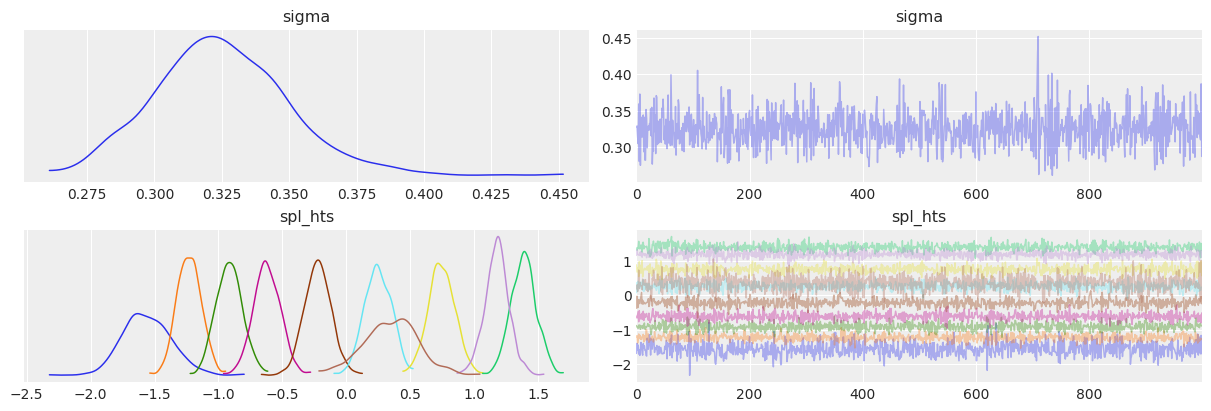

In [5]:
az.plot_trace(mcmc);

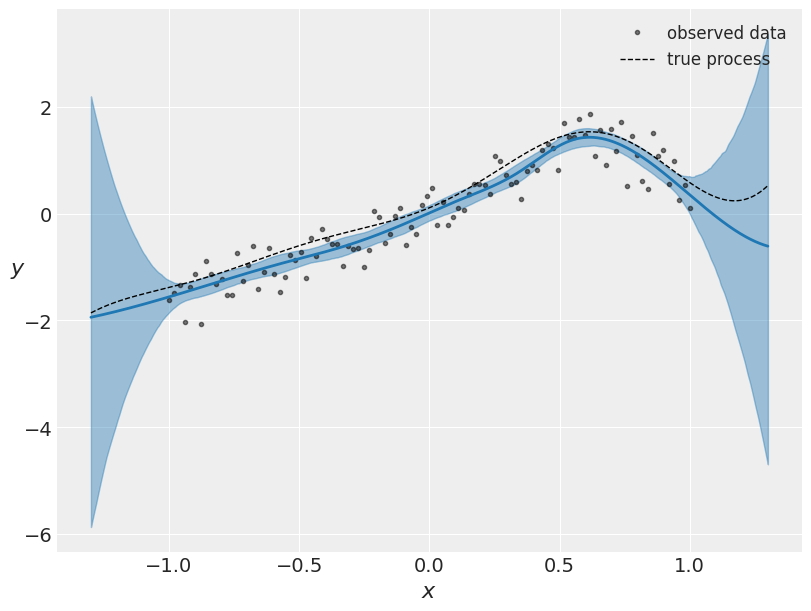

In [7]:
samples = mcmc.get_samples()
curves = []
for idx in range(1000):
    spl_hts = samples['spl_hts'][idx]
    curve = InterpolatedUnivariateSpline(knots,spl_hts)(X_test)
    curves.append(curve)

curves = np.array(curves)
mean = np.mean(curves, axis=0)
low, high = np.percentile(curves, (5, 95), axis=0)
plot_data(X, Y, X_test, Y_test)
plt.plot(X_test, mean, 'tab:blue', lw=2, label='mean')
plt.fill_between(X_test, low, high, color='tab:blue', alpha=0.4, label='90% CI')

In [8]:
import pickle
save_dict = {'X': X, 'Y': Y, 'X_test': X_test, 'knots': knots, 'samples': samples, 'curves': curves}
with open('spline_data_inference.pkl', 'wb') as f:
    pickle.dump(save_dict, f)

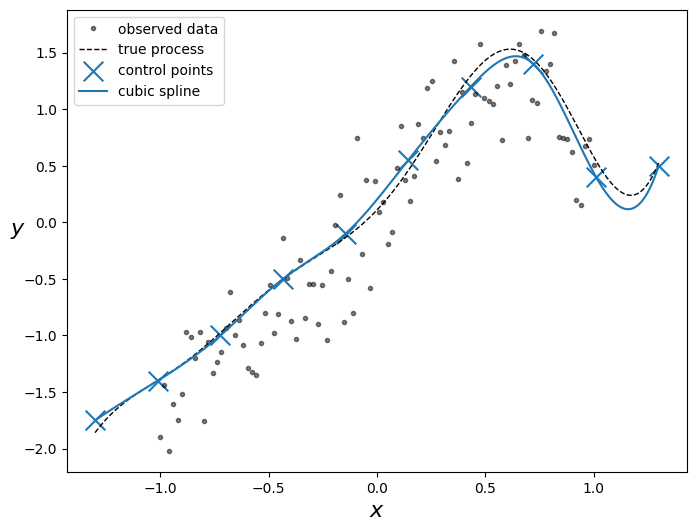

In [39]:

cont_x_pts = np.linspace(X_test[0], X_test[-1], 10)
cont_y_pts = np.array([-1.75, -1.4, -1., -0.5, -0.1, 0.55, 1.2, 1.4, 0.4, 0.5])
plot_data(X, Y, X_test, Y_test)
plt.scatter(cont_x_pts, cont_y_pts, label='control points', marker='x', s=200)
plt.plot(X_test, interp1d(cont_x_pts, cont_y_pts, kind='cubic')(X_test), label='cubic spline');
plt.legend();

In [58]:
from scipy.interpolate import interp1d

cont_x_pts = np.linspace(X_test[0], X_test[-1], 10)

def log_prior(theta):
    spl_hts = theta[:-1]
    sigma = theta[-1]
    if np.any(spl_hts < -2) | np.any(spl_hts > 2) | (sigma < 0) | (sigma > 2):
        return -np.inf
    return 0

def log_posterior(theta):
    spl_hts = theta[:-1]
    sigma = theta[-1]
    spline_curve = interp1d(cont_x_pts, spl_hts, kind='cubic')(X)
    logl = -0.5 * np.sum((Y-spline_curve)**2 / sigma**2) - 0.5 * np.log(2*np.pi*sigma**2) + log_prior(theta)
    if np.isnan(logl) | np.isinf(logl):
        return -np.inf
    return logl

ndim = 11
nwalkers = 64
nsteps = 10000
p0 = np.array([-1.75, -1.4, -1., -0.5, -0.1, 0.55, 1.2, 1.4, 0.4, 0.5, 0.25])
pos0 = np.random.randn(nwalkers, ndim) * 0.1 + p0[np.newaxis, :]
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior)
sampler.run_mcmc(pos0, nsteps, progress=True);

  0%|          | 0/10000 [00:00<?, ?it/s]/home/bedelman/anaconda3/envs/manim-env/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 10000/10000 [02:38<00:00, 63.09it/s]


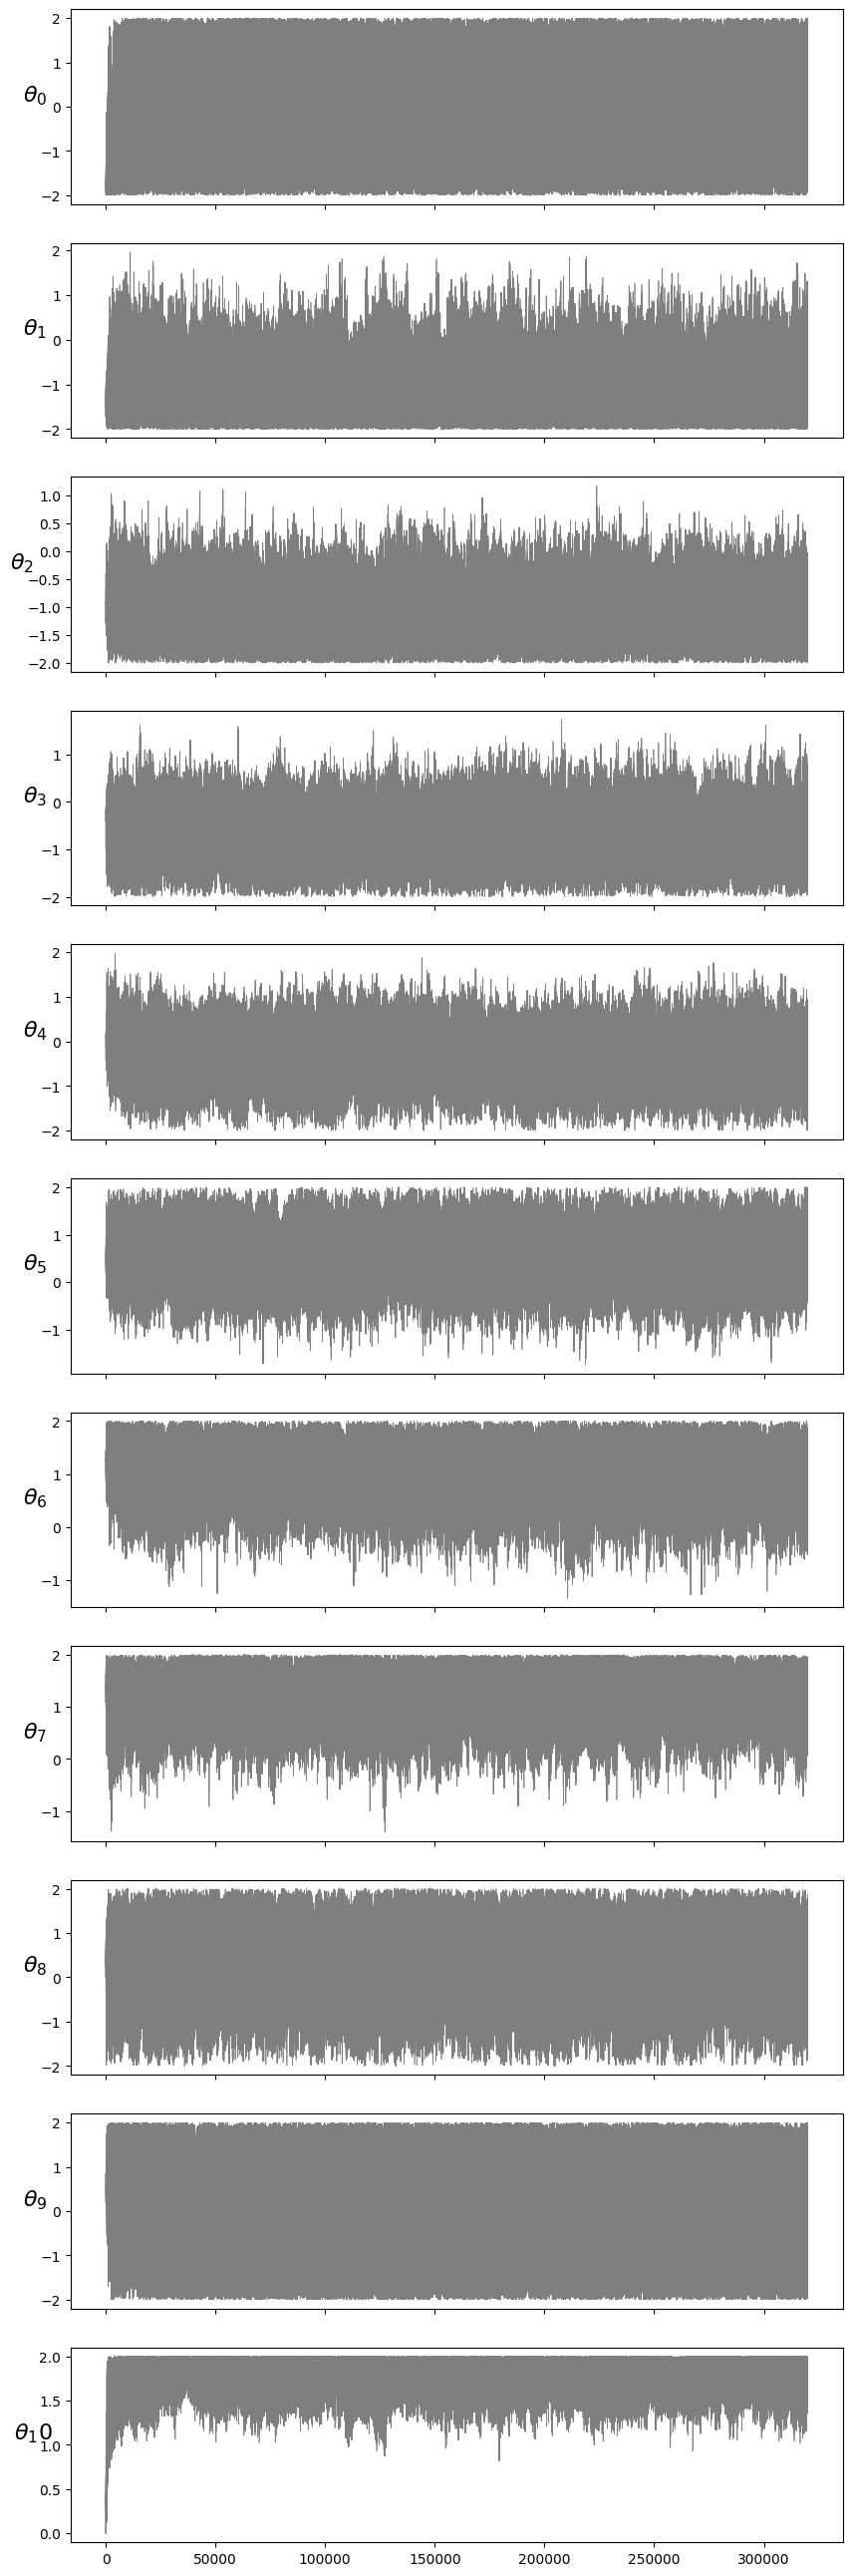

In [59]:
flat_samples = sampler.get_chain(thin=2, flat=True)
fig, axs = plt.subplots(nrows=ndim, figsize=(10, 3*ndim), sharex=True)
for i in range(ndim):
    axs[i].plot(flat_samples[:, i], 'k', lw=0.5, alpha=0.5)
    axs[i].set_ylabel(f'$\\theta_{i}$', fontsize=16, rotation=0)

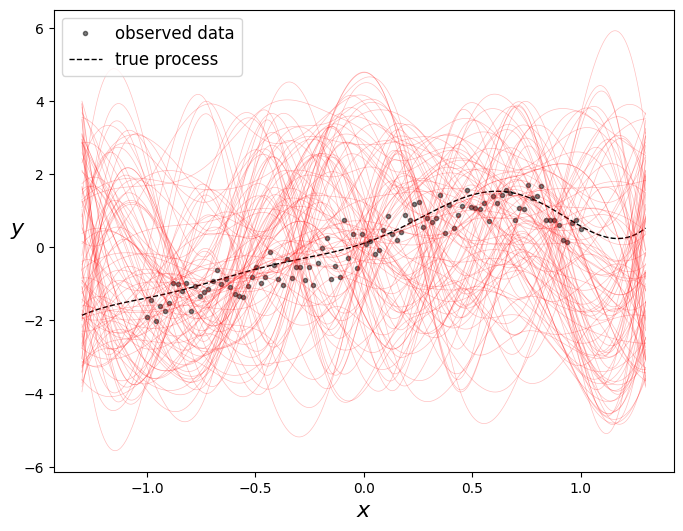

In [56]:
plot_data(X, Y, X_test, Y_test)
for i in range(100):
    idx = np.random.randint(0, flat_samples.shape[0])
    spl_hts = flat_samples[idx, :-1]
    spline_curve = interp1d(cont_x_pts, spl_hts, kind='cubic')(X_test)
    plt.plot(X_test, spline_curve, 'r', alpha=0.25, lw=0.5)